Observations:

1. One might assume that the hottest temperatures are at places on the equator or equatorial regions. However, the data suggests that the hottest temperatures are at placess slightly off the equator. On 6/20 - the highest temperature from a random sample of cities was recorded at Cuauhtemoc, MX which is situated at lat = 22.19 degrees N. However, the hotter temperatures are seen at places around the equator (N and S). Interestingly, Carhuaz in Peru being relatively closer to the equator reported the lowest temperature! The plot is shaped like a bell curve aligning with the theory that temperatures peak on/around equator and drops as we go farther away along N/S directions.

2. The plot between latitude and humidity indicates higher humidity % on and around the equator e.g. cities at 100 % humidity. The distrubution wasn't uniform. While the selection of cities was random, the distribution suggests more cities with higher humidity levels. The timing of the plot(6/20/2018) may be a factor as well - as heat waves are affecting many countries globally leading to record breaking temperatures.

3.The plot between latitude and cloudiness indicates low % of cloudiness for the data set - ~75 % of cities studied reported clear to partly cloudy skies.The timing of the plot(6/20/2018) may be a factor as well - as heat waves are affecting many countries globally leading to record breaking temperatures.

4.The plot between latitude and wind speed is interesting! The bulk of the cities studied reported low to medium wind speeds. The highest speed (31.09 MPH) was reported in Vestmanna, Faroe Islans. And islands experience stronger winds/windy conditions.



Step 1 : 

I start by importing the libraries that I need to analyze and visualize the weather across the world at a varying distance from the equator.

In [1]:
#import dependencies

import json
import requests

import numpy as np
import pandas as pd
import random 

import matplotlib.pyplot as plt
import seaborn as sns

from config import api_key
from citipy import citipy
from datetime import date


Step 2: 

I create an empty dataframe with required columns to hold the values extracted from APIs from https://openweathermap.org/api. 

Columns - "City","Country","Latitude","Temperature","Humidity","Cloudiness","Wind Speed".

In [2]:
# Define columns and Dataframe - "City","Country_Code","Latitude","Longitude"

columns =["City","Country_Code","Latitude","Longitude"]
          

Weather_Summary = pd.DataFrame(columns=columns)

Step 3: 

I define a function to generate uniform and random sets of latitude and longitude.

In [3]:
#Define function to assign random coordinates across the world, and return them when called

def lat_lon():
    lon = np.random.uniform(-180,180)
    lat = np.random.uniform(-90, 90)
    return(lat,lon)

# List comprehension to generate generate uniform and random sets of latitude and longitude

Coordinates = [lat_lon() for point in range(5000)]

Step 4: 

I use citipy library to pass the coordinates collected above and get the corresponding cities and country codes. I define the 

list of cities(Weather_Summary_Cities) randomly selected from the superset Weather_Summary.

In [4]:
# Define empty list to hold a row to write to the the dataframe

Weather_Summary_Dict = []

# Loop through coordinates, get the city name and country codes, and append to empty list defined above

for coordinate_pair in Coordinates:
    lat,lon = coordinate_pair
    City = citipy.nearest_city(lat, lon)
    Weather_Summary_Dict.append({"City": City.city_name,
                                 "Country_Code":City.country_code,
                                 "Latitude" : lat,
                                 "Longitude" : lon})

# Append the entire set of records to the dataframe; Cleaning the data to drop duplicates 

Weather_Summary = Weather_Summary.append(Weather_Summary_Dict)

Weather_Summary_Duplicates_Removed = Weather_Summary.drop_duplicates(subset=["City","Country_Code"],keep=False)


# Random selection of cities from Weather_Summary_Cities; Weather_Summary_Cities has 800 records to handle the scenario 
# that some cities may not have information retrieved from the API

Weather_Summary_Cities = Weather_Summary_Duplicates_Removed.sample(n=800)

Step 5: 

I define the base url -api.openweathermap.org/data/2.5/weather?q={city name},{country code} and pass city, country code to 

collect the attributes : "Temperature","Humidity","Cloudiness","Wind Speed". The objective is to perform a weather check on each 

city over the entire list using a series of successive API calls.

In [5]:
    # Extend the data frame to hold the new columns

    Weather_Summary_Cities["Max_Temperature"] = ""
    Weather_Summary_Cities["Humidity"] = ""
    Weather_Summary_Cities["Cloudiness"] = ""
    Weather_Summary_Cities["Wind_Speed"] = ""


    # Define base url 

    base_url = "http://api.openweathermap.org/data/2.5/find?q="

    # Define units=imperial, for temperature in Fahrenheit and Wind Speed in miles per hour
    # Source: https://openweathermap.org/weather-data

    units = "imperial"
    Records_Found = 0 

    # use iterrows to iterate through pandas dataframe
    
    for index, row in Weather_Summary_Cities.iterrows():
        
        # For better readability of the print log, the city has been translated to upper case
        
        City_Identifier = row["City"].upper()
        
        # Condition to stop the processing when 500 unique cities have been collected        
        
        if Records_Found < 500:
            
            #  Condition to check spaces in city value, and insert %20 in the api response          
            
            if " " in row["City"]:  
                City_Mod = "%20".join(row["City"].split(" "))
                url = base_url + City_Mod + "," + row["Country_Code"] + "&units=" + units +"&appid=" + api_key
                response = requests.get(url).json()
            else:
                url = base_url + row["City"] + "," + row["Country_Code"] + "&units=" + units +"&appid=" + api_key
                response = requests.get(url).json()       
            
            #  Writing the weather details to the dataframe
            
            try:
                Weather_Summary_Cities.loc[index,"Max_Temperature"] = response["list"][0]["main"]["temp_max"]
                Weather_Summary_Cities.loc[index,"Humidity"] = response["list"][0]["main"]["humidity"]
                Weather_Summary_Cities.loc[index,"Cloudiness"] = response["list"][0]["clouds"]["all"]
                Weather_Summary_Cities.loc[index,"Wind_Speed"] = response["list"][0]["wind"]["speed"]
                Records_Found = Records_Found + 1

                # Include a print log of each city and corresponding API endpoint

                print(f"Processing Record {Records_Found} | {City_Identifier}")
                print(url)       
            
            #  Indicate the records where no records were found    
            
            except:
                print("No results for city " + row["City"] + " found!")
                continue     
                
    # Determines successful processing and collection of weather details for 500 unique cities
    
    print(f"{Records_Found} unique cities are ready for further analysis!")

Processing Record 1 | VIRGINIA BEACH
http://api.openweathermap.org/data/2.5/find?q=virginia%20beach,us&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 2 | PINGXIANG
http://api.openweathermap.org/data/2.5/find?q=pingxiang,cn&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 3 | HAVERFORDWEST
http://api.openweathermap.org/data/2.5/find?q=haverfordwest,gb&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 4 | CAP-AUX-MEULES
http://api.openweathermap.org/data/2.5/find?q=cap-aux-meules,ca&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 5 | TIMRA
http://api.openweathermap.org/data/2.5/find?q=timra,se&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 6 | GORIN
http://api.openweathermap.org/data/2.5/find?q=gorin,ru&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 7 | WINFIELD
http://api.openweathermap.org/data/2.5/find?q=winfield,us&units=imperial&appid=25bc90

Processing Record 57 | PALAMPUR
http://api.openweathermap.org/data/2.5/find?q=palampur,in&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 58 | AGOGO
http://api.openweathermap.org/data/2.5/find?q=agogo,gh&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 59 | NANTUCKET
http://api.openweathermap.org/data/2.5/find?q=nantucket,us&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 60 | LEKONI
http://api.openweathermap.org/data/2.5/find?q=lekoni,ga&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 61 | SHATURTORF
http://api.openweathermap.org/data/2.5/find?q=shaturtorf,ru&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 62 | BEREA
http://api.openweathermap.org/data/2.5/find?q=berea,us&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 63 | KALACH-NA-DONU
http://api.openweathermap.org/data/2.5/find?q=kalach-na-donu,ru&units=imperial&appid=25bc90a1196e6f153eece0b

Processing Record 113 | PANGOA
http://api.openweathermap.org/data/2.5/find?q=pangoa,pe&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 114 | USHTOBE
http://api.openweathermap.org/data/2.5/find?q=ushtobe,kz&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 115 | CAMPBELL RIVER
http://api.openweathermap.org/data/2.5/find?q=campbell%20river,ca&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 116 | DERZHAVINSK
http://api.openweathermap.org/data/2.5/find?q=derzhavinsk,kz&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 117 | TURINSKAYA SLOBODA
http://api.openweathermap.org/data/2.5/find?q=turinskaya%20sloboda,ru&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 118 | SADOVOYE
http://api.openweathermap.org/data/2.5/find?q=sadovoye,ru&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 119 | BIDA
http://api.openweathermap.org/data/2.5/find?q=bida,ng&units=imper

Processing Record 169 | TALCAHUANO
http://api.openweathermap.org/data/2.5/find?q=talcahuano,cl&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 170 | SI RACHA
http://api.openweathermap.org/data/2.5/find?q=si%20racha,th&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 171 | GALLE
http://api.openweathermap.org/data/2.5/find?q=galle,lk&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
No results for city hongan found!
Processing Record 172 | BRAE
http://api.openweathermap.org/data/2.5/find?q=brae,gb&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 173 | JARU
http://api.openweathermap.org/data/2.5/find?q=jaru,br&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 174 | CHIFENG
http://api.openweathermap.org/data/2.5/find?q=chifeng,cn&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 175 | TEAHUPOO
http://api.openweathermap.org/data/2.5/find?q=teahupoo,pf&units=imperial&appid=25

Processing Record 223 | POLUNOCHNOYE
http://api.openweathermap.org/data/2.5/find?q=polunochnoye,ru&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 224 | CARBALLO
http://api.openweathermap.org/data/2.5/find?q=carballo,es&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 225 | CAALA
http://api.openweathermap.org/data/2.5/find?q=caala,ao&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 226 | BOA VISTA
http://api.openweathermap.org/data/2.5/find?q=boa%20vista,br&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 227 | UST-KUYGA
http://api.openweathermap.org/data/2.5/find?q=ust-kuyga,ru&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
No results for city eldikan found!
No results for city lgov found!
Processing Record 228 | POZZUOLI
http://api.openweathermap.org/data/2.5/find?q=pozzuoli,it&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 229 | A CORUNA
http://api.openweather

Processing Record 279 | ALAMOS
http://api.openweathermap.org/data/2.5/find?q=alamos,mx&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 280 | CORDOBA
http://api.openweathermap.org/data/2.5/find?q=cordoba,ar&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 281 | PORT AUGUSTA
http://api.openweathermap.org/data/2.5/find?q=port%20augusta,au&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
No results for city wampusirpi found!
Processing Record 282 | AXAMS
http://api.openweathermap.org/data/2.5/find?q=axams,at&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 283 | PUERTO CABEZAS
http://api.openweathermap.org/data/2.5/find?q=puerto%20cabezas,ni&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 284 | COLLEGE PLACE
http://api.openweathermap.org/data/2.5/find?q=college%20place,us&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 285 | BOM JESUS
http://api.openweathermap.org/data

No results for city deh rawud found!
Processing Record 335 | ZAOZERNE
http://api.openweathermap.org/data/2.5/find?q=zaozerne,ua&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 336 | ZIARAT
http://api.openweathermap.org/data/2.5/find?q=ziarat,pk&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 337 | JIAYUGUAN
http://api.openweathermap.org/data/2.5/find?q=jiayuguan,cn&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 338 | MPONELA
http://api.openweathermap.org/data/2.5/find?q=mponela,mw&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 339 | UGOOFAARU
http://api.openweathermap.org/data/2.5/find?q=ugoofaaru,mv&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 340 | TAHLEQUAH
http://api.openweathermap.org/data/2.5/find?q=tahlequah,us&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 341 | NUROTA
http://api.openweathermap.org/data/2.5/find?q=nurota,uz&units=

Processing Record 389 | SINGAPARNA
http://api.openweathermap.org/data/2.5/find?q=singaparna,id&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 390 | MIRAMAR
http://api.openweathermap.org/data/2.5/find?q=miramar,mx&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
No results for city kuytun found!
Processing Record 391 | THOEN
http://api.openweathermap.org/data/2.5/find?q=thoen,th&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 392 | BINTULU
http://api.openweathermap.org/data/2.5/find?q=bintulu,my&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 393 | LA ROMANA
http://api.openweathermap.org/data/2.5/find?q=la%20romana,do&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 394 | KATHERINE
http://api.openweathermap.org/data/2.5/find?q=katherine,au&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 395 | RACH GIA
http://api.openweathermap.org/data/2.5/find?q=rach%20gia,vn&uni

Processing Record 443 | JALU
http://api.openweathermap.org/data/2.5/find?q=jalu,ly&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 444 | BRANDON
http://api.openweathermap.org/data/2.5/find?q=brandon,us&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 445 | LANGXIANG
http://api.openweathermap.org/data/2.5/find?q=langxiang,cn&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 446 | CHINA
http://api.openweathermap.org/data/2.5/find?q=china,mx&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 447 | LAVUMISA
http://api.openweathermap.org/data/2.5/find?q=lavumisa,sz&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 448 | LOS CHILES
http://api.openweathermap.org/data/2.5/find?q=los%20chiles,cr&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 449 | VOLAX
http://api.openweathermap.org/data/2.5/find?q=volax,gr&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb

Processing Record 498 | ELKO
http://api.openweathermap.org/data/2.5/find?q=elko,us&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 499 | ILABAYA
http://api.openweathermap.org/data/2.5/find?q=ilabaya,pe&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
Processing Record 500 | ARROYOS Y ESTEROS
http://api.openweathermap.org/data/2.5/find?q=arroyos%20y%20esteros,py&units=imperial&appid=25bc90a1196e6f153eece0bc0b0fc9eb
500 unique cities are ready for further analysis!


Step 6: 

In the next few cells, I use data wrangling methods within pandas dataframe to make the data readable and presentable.

In [6]:
# Define the new dataframe with 500 cities for visualization tasks

Weather_Summary_Cities_500 = Weather_Summary_Cities[Weather_Summary_Cities["Max_Temperature"] != ""]

# Reset the index and drop the column with existing index

Weather_Summary_Cities_500_Reindexed = Weather_Summary_Cities_500.reset_index(drop=True)

Weather_Summary_Cities_500_Reindexed.head()

,City,Country_Code,Latitude,Longitude,Max_Temperature,Humidity,Cloudiness,Wind_Speed
0,virginia beach,us,36.864671,-73.941731,78.8,88,40,4.7
1,pingxiang,cn,27.166195,113.997337,75.6,100,92,3.74
2,haverfordwest,gb,51.348121,-4.768443,54.09,100,12,16.71
3,cap-aux-meules,ca,48.023176,-61.163542,57.2,71,90,12.75
4,timra,se,64.207501,16.506817,51.8,62,44,5.82


In [7]:
# Convert City to start with capital case ; Convert Country Coder to upper case

Weather_Summary_Cities_500_Reindexed["City"] = Weather_Summary_Cities_500_Reindexed.City.str.title()

Weather_Summary_Cities_500_Reindexed["Country_Code"] = Weather_Summary_Cities_500_Reindexed.Country_Code.str.upper()

In [8]:
Weather_Summary_Cities_500_Reindexed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
City               500 non-null object
Country_Code       500 non-null object
Latitude           500 non-null float64
Longitude          500 non-null float64
Max_Temperature    500 non-null object
Humidity           500 non-null object
Cloudiness         500 non-null object
Wind_Speed         500 non-null object
dtypes: float64(2), object(6)
memory usage: 31.3+ KB


In [9]:
# Create bins to identify temperature, humidity, Cloudiness. This will help in insightful visualizations
# The categories and bins have been indentified based on my experience, and readings / heat maps available through Google Images

Temp_Bin = [20,50,70,200]

Temp_Group_Names = ["Cold","Optimum","Hot"]

Weather_Summary_Cities_500_Reindexed["Temperature_Category"] = pd.cut(Weather_Summary_Cities_500_Reindexed["Max_Temperature"],
                                                                      Temp_Bin,labels=Temp_Group_Names)

Humidity_Bin = [0,35,75,101]

Humidity_Group_Names = ["Dry","Optimum","Moist"]

Weather_Summary_Cities_500_Reindexed["Humidity_Category"] = pd.cut(Weather_Summary_Cities_500_Reindexed["Humidity"],
                                                                      Humidity_Bin,labels=Humidity_Group_Names)

Cloudiness_Bin = [-1,30,70,101]

Cloudiness_Group_Names = ["Clear","Partly_Cloudy","Cloudy"]

Weather_Summary_Cities_500_Reindexed["Cloudiness_Category"] = pd.cut(Weather_Summary_Cities_500_Reindexed["Cloudiness"],
                                                            Cloudiness_Bin,labels=Cloudiness_Group_Names)

Weather_Summary_Cities_500_Reindexed.head()

,City,Country_Code,Latitude,Longitude,Max_Temperature,Humidity,Cloudiness,Wind_Speed,Temperature_Category,Humidity_Category,Cloudiness_Category
0,Virginia Beach,US,36.864671,-73.941731,78.8,88,40,4.7,Hot,Moist,Partly_Cloudy
1,Pingxiang,CN,27.166195,113.997337,75.6,100,92,3.74,Hot,Moist,Cloudy
2,Haverfordwest,GB,51.348121,-4.768443,54.09,100,12,16.71,Optimum,Moist,Clear
3,Cap-Aux-Meules,CA,48.023176,-61.163542,57.2,71,90,12.75,Optimum,Optimum,Cloudy
4,Timra,SE,64.207501,16.506817,51.8,62,44,5.82,Optimum,Optimum,Partly_Cloudy


Step 7 :

I use seaborn libraries (lmplot) to plot the illustrate weather attributes vs Latitude.

City Latitude vs Max Temperature -

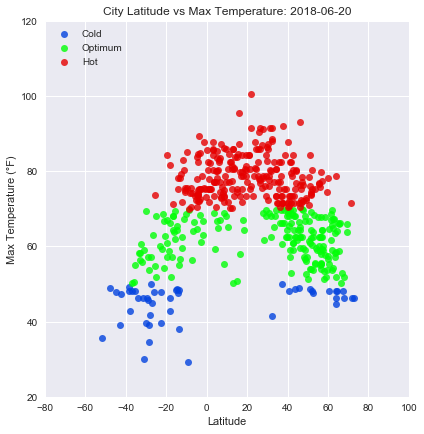

In [10]:
# Define the lmplot structure

sns.set()

sns.set_context("notebook")

sns_plot1 = sns.lmplot( x="Latitude", y="Max_Temperature",size=6, data = Weather_Summary_Cities_500_Reindexed,fit_reg=False, 
           hue="Temperature_Category", legend=False, palette=dict(Cold="#0343df",Optimum="#01ff07",Hot="#e50000"))

Today_Date = str(date.today())

# Label the plot

Plot_Title = f"City Latitude vs Max Temperature: {Today_Date}"
plt.title(Plot_Title)

plt.xlabel("Latitude")
plt.ylabel("Max Temperature (°F)")

plt.xlim(-80,100)
plt.ylim(20, 120)

plt.legend(loc='upper left')

# Save the image and display

sns_plot1.savefig("../Images/Latitude_vs_MaxTemperature.png")

plt.show(sns_plot1)

Step 8:

City Latitude vs Humidity -

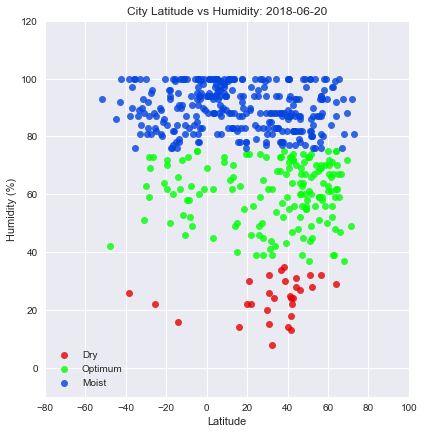

In [11]:
# Define the lmplot structure

sns.set()

sns.set_context("notebook")

sns_plot2 = sns.lmplot( x="Latitude", y="Humidity",size=6,data = Weather_Summary_Cities_500_Reindexed,fit_reg=False, 
           hue="Humidity_Category", legend=False, palette=dict(Moist="#0343df",Optimum="#01ff07",Dry="#e50000"))

# Label the plot

Plot_Title = f"City Latitude vs Humidity: {Today_Date}"
plt.title(Plot_Title)

plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")

plt.xlim(-80,100)
plt.ylim(-10, 120)

plt.legend(loc='lower left')

# Save the image and display

sns_plot2.savefig("../Images/Latitude_vs_Humidity.png")


plt.show(sns_plot2)


Step 9 :

City Latitude vs Cloudness (%) -

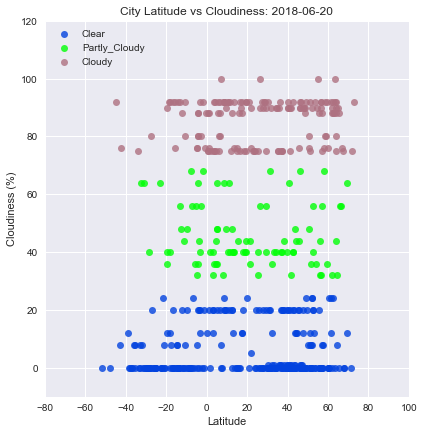

In [12]:
# Define the lmplot structure

sns.set()

sns.set_context("notebook")

sns_plot3 = sns.lmplot( x="Latitude", y="Cloudiness",size=6, data = Weather_Summary_Cities_500_Reindexed,fit_reg=False, 
           hue="Cloudiness_Category", legend=False, palette=dict(Clear="#0343df", Partly_Cloudy="#01ff07",Cloudy="#ae7181"))

# Label the plot

Plot_Title = f"City Latitude vs Cloudiness: {Today_Date}"
plt.title(Plot_Title)

plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

plt.xlim(-80,100)
plt.ylim(-10, 120)

plt.legend(loc='upper left')

# Save the image and display

sns_plot3.savefig("../Images/Latitude_vs_Cloudiness.png")

plt.show(sns_plot3)


Step 10 :

City Latitude vs Wind Speed -

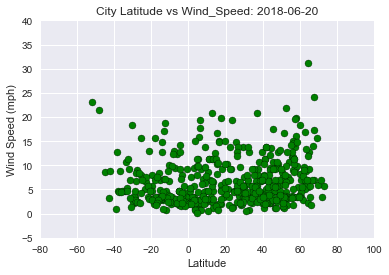

In [13]:
# Define the scatter plot structure

plt.scatter(Weather_Summary_Cities_500_Reindexed["Latitude"], 
            Weather_Summary_Cities_500_Reindexed["Wind_Speed"],marker="o", facecolors="green", edgecolors="black")

# Label the plot

Plot_Title = f"City Latitude vs Wind_Speed: {Today_Date}"
plt.title(Plot_Title)

plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")

plt.xlim(-80,100)
plt.ylim(-5,40)

# Save the image and display

plt.savefig("../Images/Latitude_vs_WindSpeed.png")

plt.show()

In [14]:
# Save the comprehensive dataframe to CSV

Weather_Summary_Cities_500_Reindexed.to_csv("../Resources/WeatherData_500Cities.csv", index=False, header=True)

Step 11:

I use pairplot from searborn library to look at the analysis in one canvas.

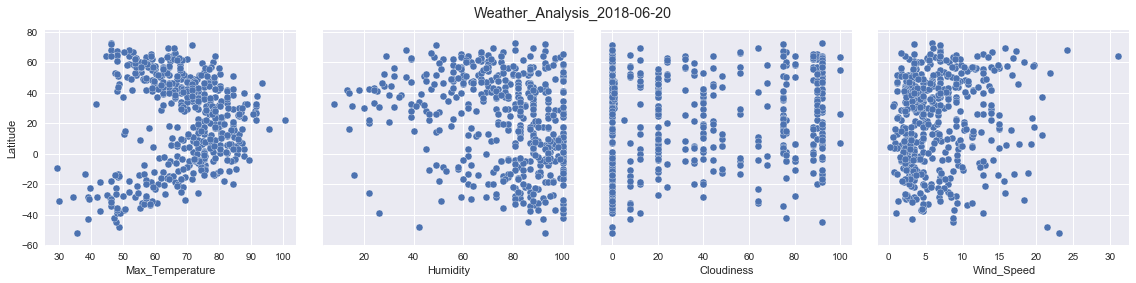

In [15]:
# Define the pairplot structure

sns.set()

sns.set_context("notebook")

sns_plot4 = sns.pairplot(Weather_Summary_Cities_500_Reindexed, size = 4,
             y_vars=["Latitude"],
             x_vars=["Max_Temperature","Humidity","Cloudiness","Wind_Speed"])

# Label the plot

Plot_Title = f"Weather_Analysis_{Today_Date}"

plt.subplots_adjust(top=0.9)

sns_plot4.fig.suptitle(Plot_Title)

sns_plot4.savefig(f"../Images/{Plot_Title}.png")

plt.show(sns_plot4)